In [1]:
import numpy as np
import pandas as pd

from scipy import stats, odr

from statsmodels.stats.weightstats import ztest
import matplotlib.pyplot as plt
import seaborn as sns

# Input Data

In [2]:
# Drug tested M
dt_total_m = pd.read_pickle('DT_Total_M.pkl')
dt_bench_m = pd.read_pickle('DT_Bench_M.pkl')
dt_squat_m = pd.read_pickle('DT_Squat_M.pkl')
dt_dead_m = pd.read_pickle('DT_Dead_M.pkl') 

# Drug tested F
dt_total_f = pd.read_pickle('DT_Total_F.pkl')
dt_bench_f = pd.read_pickle('DT_Bench_F.pkl')
dt_squat_f = pd.read_pickle('DT_Squat_F.pkl')
dt_dead_f = pd.read_pickle('DT_Dead_F.pkl') 

# Non Drug tested M
ndt_total_m = pd.read_pickle('NDT_Total_M.pkl')
ndt_bench_m = pd.read_pickle('NDT_Bench_M.pkl')
ndt_squat_m = pd.read_pickle('NDT_Squat_M.pkl')
ndt_dead_m = pd.read_pickle('NDT_Dead_M.pkl') 

# Non Drug tested F
ndt_total_f = pd.read_pickle('NDT_Total_F.pkl')
ndt_bench_f = pd.read_pickle('NDT_Bench_F.pkl')
ndt_squat_f = pd.read_pickle('NDT_Squat_F.pkl')
ndt_dead_f = pd.read_pickle('NDT_Dead_F.pkl') 

# General Population M
gp_total_m = pd.read_pickle('GP_Total_M.pkl')
gp_bench_m = pd.read_pickle('GP_Bench_M.pkl')
gp_squat_m = pd.read_pickle('GP_Squat_M.pkl')
gp_dead_m = pd.read_pickle('GP_Dead_M.pkl') 

# General Population F
gp_total_f = pd.read_pickle('GP_Total_F.pkl')
gp_bench_f = pd.read_pickle('GP_Bench_F.pkl')
gp_squat_f = pd.read_pickle('GP_Squat_F.pkl')
gp_dead_f = pd.read_pickle('GP_Dead_F.pkl') 

# Visualizations

Peak Age for each Weight Group across the different populations.

In [3]:
def pop_label(df, label):
    df.loc[:,'Population'] = label
    return df

In [4]:
total = pd.concat([pop_label(dt_total_m,'Drug Tested'),pop_label(ndt_total_m,'Non Drug Tested'),
           pop_label(gp_total_m,'General Population'),
          pop_label(dt_total_f,'Drug Tested'),pop_label(ndt_total_f,'Non Drug Tested'),
           pop_label(gp_total_f,'General Population')],
          axis = 0, ignore_index = True)
bench = pd.concat([pop_label(dt_bench_m,'Drug Tested'),pop_label(ndt_bench_m,'Non Drug Tested'),
           pop_label(gp_bench_m,'General Population'),
          pop_label(dt_bench_f,'Drug Tested'),pop_label(ndt_bench_f,'Non Drug Tested'),
           pop_label(gp_bench_f,'General Population')],
          axis = 0, ignore_index = True)
squat = pd.concat([pop_label(dt_squat_m,'Drug Tested'),pop_label(ndt_squat_m,'Non Drug Tested'),
           pop_label(gp_squat_m,'General Population'),
          pop_label(dt_squat_f,'Drug Tested'),pop_label(ndt_squat_f,'Non Drug Tested'),
           pop_label(gp_squat_f,'General Population')],
          axis = 0, ignore_index = True)
dead = pd.concat([pop_label(dt_dead_m,'Drug Tested'),pop_label(ndt_dead_m,'Non Drug Tested'),
           pop_label(gp_dead_m,'General Population'),
          pop_label(dt_dead_f,'Drug Tested'),pop_label(ndt_dead_f,'Non Drug Tested'),
           pop_label(gp_dead_f,'General Population')],
          axis = 0, ignore_index = True)

In [5]:
def quad_plot_age(total, bench, squat, dead, sex):
    fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))

    axs[0,0].set_title('Mean Age for Peak Total Weight Lifted for '+sex)
    axs[0,1].set_title('Mean Age for Peak Bench Press for '+sex)
    axs[1,0].set_title('Mean Age for Peak Squat for '+sex)
    axs[1,1].set_title('Mean Age for Peak Deadlift for '+sex)

    sns.barplot(total[total['Sex'] == sex].copy().groupby(['Weight','Population'])['Age'].mean().reset_index(),
                x = 'Weight', y = 'Age', hue = 'Population', ax = axs[0,0])
    sns.move_legend(axs[0,0], 'upper left', bbox_to_anchor=(1, 1))

    sns.barplot(bench[bench['Sex'] == sex].copy().groupby(['Weight','Population'])['Age'].mean().reset_index(),
                x = 'Weight', y = 'Age', hue = 'Population', ax = axs[0,1])
    sns.move_legend(axs[0,1], 'upper left', bbox_to_anchor=(1, 1))
    
    sns.barplot(squat[squat['Sex'] == sex].copy().groupby(['Weight','Population'])['Age'].mean().reset_index(),
                x = 'Weight', y = 'Age', hue = 'Population', ax = axs[1,0])
    sns.move_legend(axs[1,0], 'upper left', bbox_to_anchor=(1, 1))
    
    sns.barplot(dead[dead['Sex'] == sex].copy().groupby(['Weight','Population'])['Age'].mean().reset_index(),
                x = 'Weight', y = 'Age', hue = 'Population', ax = axs[1,1])
    sns.move_legend(axs[1,1], 'upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()

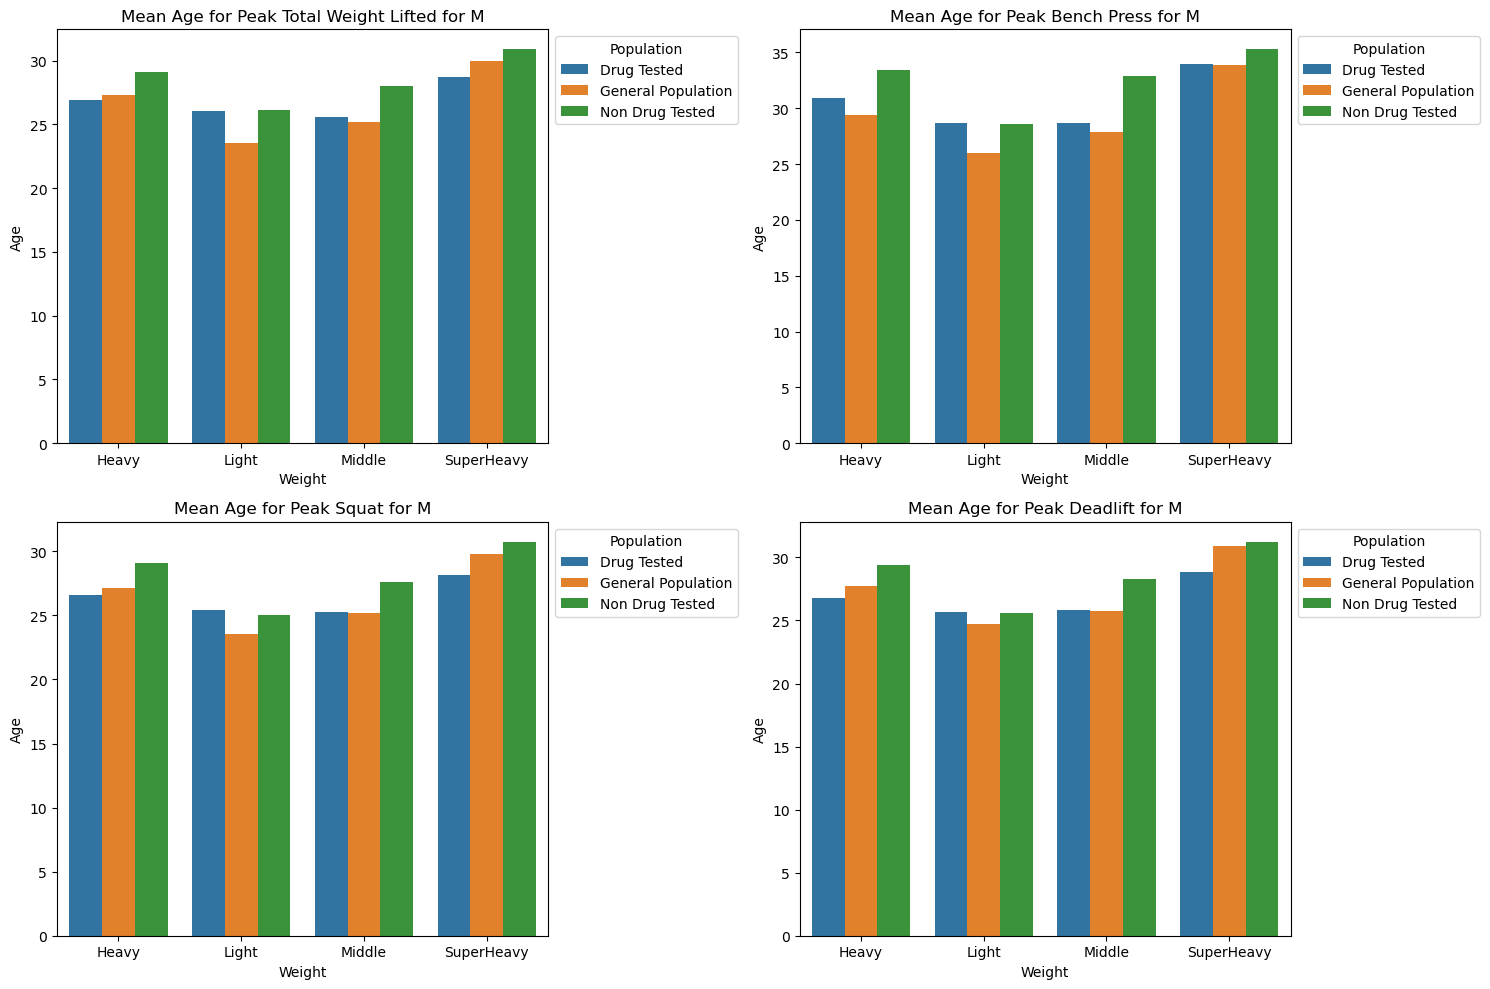

In [6]:
quad_plot_age(total, bench, squat, dead, 'M')

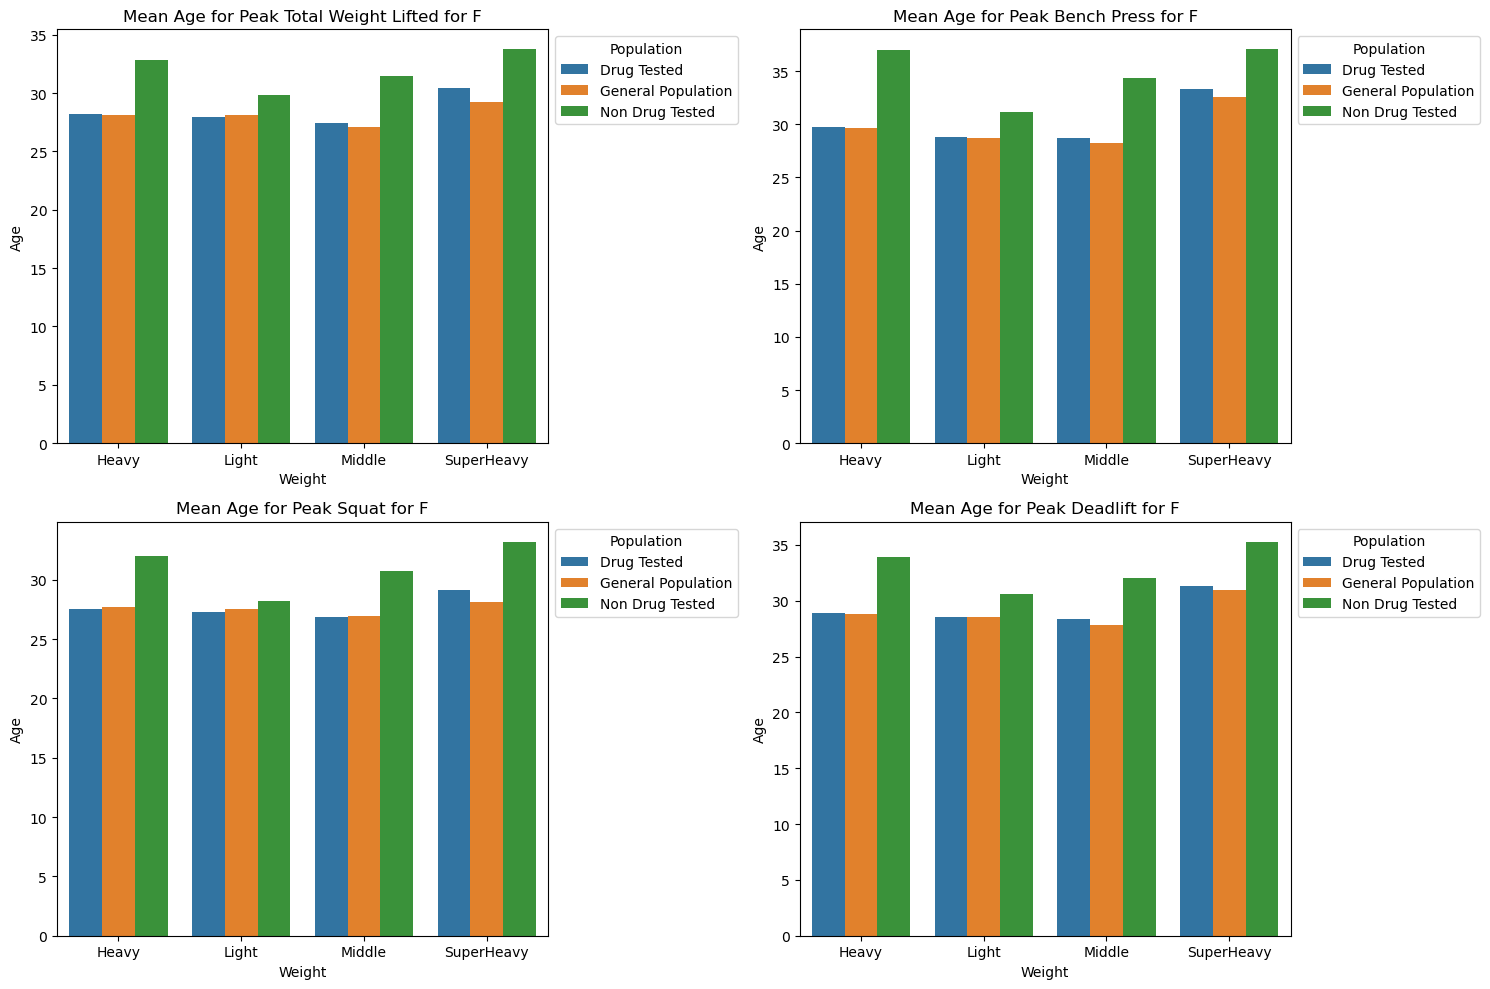

In [7]:
quad_plot_age(total, bench, squat, dead, 'F')

# Statistical Testing for Difference in Means

In [8]:
def mean_age_difference_z_test(total, sex, alpha):
    results = {}
    df = total.copy()
    weight_groups = df['Weight'].unique()
    for weight_group in weight_groups:
        pop_groups = df[df['Weight'] == weight_group]['Population'].unique()
        for i in range(len(pop_groups)):
            for j in range(i + 1, len(pop_groups)):
                population1 = pop_groups[i]
                population2 = pop_groups[j]
                
                sample1 = df[(df['Population'] == population1) & (df['Weight'] == weight_group) & (df['Sex'] == sex)]['Age']
                sample2 = df[(df['Population'] == population2) & (df['Weight'] == weight_group) & (df['Sex'] == sex)]['Age']
                z_stat, p_value = ztest(sample1, sample2)

                p_value_formatted = '{:.5f}'.format(p_value) 

                if p_value < alpha:
                    decision = 'Reject H0: There is a significant difference'
                else:
                    decision = 'Fail to reject H0: There is no significant difference'

                results[f'{weight_group} {population1} vs {population2}'] = {'Z statistic': z_stat,
                                                     'p-value': p_value_formatted,
                                                     'Decision': decision}
    print(df.groupby(['Weight','Population'])['Age'].describe())
    return results

In [9]:
mean_age_difference_z_test(total,'F',.05)

                                 count       mean       std   min   25%  \
Weight     Population                                                     
Heavy      Drug Tested         15429.0  27.386318  6.782371  13.0  22.5   
           General Population   7745.0  27.542802  8.590755  14.5  21.5   
           Non Drug Tested      4016.0  30.509213  7.768637  15.0  25.0   
Light      Drug Tested          4104.0  26.776803  7.049528  15.0  21.5   
           General Population   2166.0  25.258541  8.920349  12.5  19.5   
           Non Drug Tested       512.0  27.625000  7.162019  15.0  23.0   
Middle     Drug Tested         13299.0  26.158734  6.307931  14.5  21.5   
           General Population   6833.0  25.502927  8.125925  14.0  20.5   
           Non Drug Tested      2356.0  29.036715  7.960427  15.0  23.0   
SuperHeavy Drug Tested          5657.0  29.349213  7.294950  14.5  23.5   
           General Population   2911.0  29.795775  9.377055  14.5  22.5   
           Non Drug Teste

{'Heavy Drug Tested vs Non Drug Tested': {'Z statistic': -20.666907064784798,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy Drug Tested vs General Population': {'Z statistic': 0.27844612430015403,
  'p-value': '0.78067',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Heavy Non Drug Tested vs General Population': {'Z statistic': 17.68923250095024,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light Drug Tested vs Non Drug Tested': {'Z statistic': -3.4735989643089047,
  'p-value': '0.00051',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light Drug Tested vs General Population': {'Z statistic': -0.4022019976276756,
  'p-value': '0.68754',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light Non Drug Tested vs General Population': {'Z statistic': 3.175459983711476,
  'p-value': '0.00150',
  'Decision': 'Reject H0: There is a si

In [10]:
mean_age_difference_z_test(total,'M',.05)

                                 count       mean       std   min   25%  \
Weight     Population                                                     
Heavy      Drug Tested         15429.0  27.386318  6.782371  13.0  22.5   
           General Population   7745.0  27.542802  8.590755  14.5  21.5   
           Non Drug Tested      4016.0  30.509213  7.768637  15.0  25.0   
Light      Drug Tested          4104.0  26.776803  7.049528  15.0  21.5   
           General Population   2166.0  25.258541  8.920349  12.5  19.5   
           Non Drug Tested       512.0  27.625000  7.162019  15.0  23.0   
Middle     Drug Tested         13299.0  26.158734  6.307931  14.5  21.5   
           General Population   6833.0  25.502927  8.125925  14.0  20.5   
           Non Drug Tested      2356.0  29.036715  7.960427  15.0  23.0   
SuperHeavy Drug Tested          5657.0  29.349213  7.294950  14.5  23.5   
           General Population   2911.0  29.795775  9.377055  14.5  22.5   
           Non Drug Teste

{'Heavy Drug Tested vs Non Drug Tested': {'Z statistic': -15.46065831383351,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy Drug Tested vs General Population': {'Z statistic': -3.4263948026686752,
  'p-value': '0.00061',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy Non Drug Tested vs General Population': {'Z statistic': 8.742700812134373,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light Drug Tested vs Non Drug Tested': {'Z statistic': -0.038730123097469094,
  'p-value': '0.96911',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light Drug Tested vs General Population': {'Z statistic': 9.4609897210361,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light Non Drug Tested vs General Population': {'Z statistic': 4.39592579951382,
  'p-value': '0.00001',
  'Decision': 'Reject H0: There is a significant dif